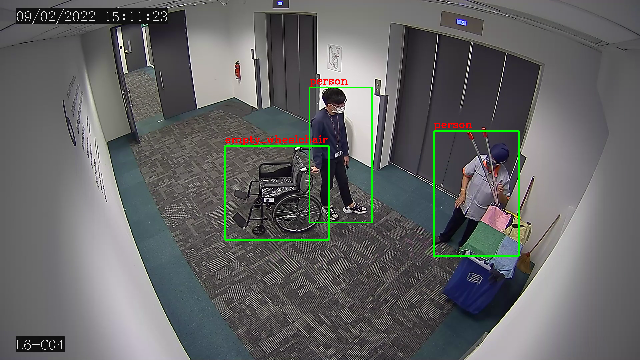

FrameID range is from  890.0  to  900.0 total rows: 2
timer: 70.37937498092651
------------SKIP TO SEND DASHBOARD.


error: OpenCV(4.5.3) /tmp/pip-req-build-s58vuwxh/opencv/modules/imgcodecs/src/loadsave.cpp:978: error: (-215:Assertion failed) !image.empty() in function 'imencode'


In [8]:
import base64
import io
import requests
import json
import time
import sqlite3
import glob
import numpy as np
import imutils
import math
import os,sys, os.path
import shutil
from IPython.display import Image, clear_output, display
import cv2
get_ipython().run_line_magic('matplotlib', 'inline')
from matplotlib import pyplot as plt
from os import listdir
from os.path import isfile, isdir, join
from shapely import geometry
from pathlib import Path
from datetime import datetime
from datetime import timedelta
from aialertconfig import AIAlertConfig
from requests_toolbelt.multipart.encoder import MultipartEncoder
from requests.auth import HTTPBasicAuth 

datasetPath = "./test/"
resultPath = "./result/"
inferenceIP = "inf1647239194116-i-clusterip-svc"
inferencePort = "9999"

def updateTime():
    global updateT
    updateT=time.time()
    return updateT

def detect_sql_lite(dbname):
    conn = sqlite3.connect(dbname)
    c = conn.cursor()
    sql = '''CREATE TABLE DETECTIONS (FRAMEID INT NOT NULL,NAME TEXT, ACCURACY TEXT, X_POINT TEXT, Y_POINT TEXT,W_SIZE TEXT, H_SIZE TEXT);'''
    c.execute(sql)
    print ("detect database ready...")
    conn.commit()
    conn.close()

def sendPost(updateT):
    timer=time.time()-updateT
    print("timer:",timer)
    if timer < 3.0 :
        aievent_alert=AIEvent_Alert(AIEvent_Alert_CallBack)
        aievent_alert.EventAlertJsonSend("detect_image.jpg")
    if 2.0 <= timer <= 90 :
        print("------------SKIP TO SEND DASHBOARD.")
    if timer > 90: 
        aievent_alert=AIEvent_Alert(AIEvent_Alert_CallBack)
        aievent_alert.EventAlertJsonSend("detect_image.jpg")
        updateT= updateTime()
        time.sleep(3)
        print("Newtime is:",updateT)

def arrayShow(imageArray):
    resized = cv2.resize(imageArray, (640, 360), interpolation=cv2.INTER_CUBIC)
    ret, png = cv2.imencode('.png', resized)
    return Image(data=png)

def videosTest():
    #f = "temp.png"
    #OUTPUT = join(resultPath,f)
    cap = cv2.VideoCapture("L6-C04.mp4")
    ret = cap.isOpened()
    while ret:
        ret,frame = cap.read()
        frame_ori = frame
        frameid = cap.get(1)
        iloop=1  # 3 per/sec
        while iloop:
            cap.grab()  #only get frame, not processing
            frameid = cap.get(1)
            iloop =iloop - 1
            if iloop <1 :
                break 
        data=base64.b64encode(cv2.imencode('.jpg',frame)[1]).decode()
        body = {"image": data, "thresh": 0.5, "getImage": False}
        res = requests.post("http://" + inferenceIP +":" + inferencePort + "/darknet/detect", json=body)
        detected = res.json()
        objects = detected.get('results')
        print(detected)
        for obj in objects:
            bounding = obj.get('bounding')
            name = obj.get('name')
            height = bounding.get('height')
            width = bounding.get('width')
            score = obj.get('score')
            x_point = str(bounding.get('x'))
            y_point = str(bounding.get('y'))
            w_size = str(bounding.get('width'))
            h_size = str(bounding.get('height'))
            accuracy = str(score)
            payload_location = [x_point,y_point,w_size,h_size]
            payload_probability = accuracy
            detect_log = 'class:{!s} confidence:{!s}'.format(str(name), str(score))
            # add to sqlite            
            conn = sqlite3.connect(dbname)
            c = conn.cursor()
            sql="""INSERT INTO DETECTIONS(FRAMEID, NAME, ACCURACY, X_POINT, Y_POINT,W_SIZE, H_SIZE) VALUES (%s,%s,%s,%s,%s,%s,%s)""" %(frameid,"'"+name+"'","'"+accuracy+"'","'"+x_point+"'","'"+y_point+"'","'"+w_size+"'","'"+h_size+"'")
            c.execute(sql)
            conn.commit()
            conn.close()
        
        oriImage = frame
        color = (0, 255, 0)
        for obj in objects:
            bounding = obj.get('bounding')
            name = obj.get('name')
            height = bounding.get('height')
            width = bounding.get('width')
            left = bounding.get('x') - (width/2)
            top = bounding.get('y') - (height/2)
            right = bounding.get('x') + (width/2)
            bottom = bounding.get('y') + (height/2)
            cv2.putText(oriImage, name, (int(left), int(max((top - 10),0))), cv2.FONT_HERSHEY_COMPLEX, 1, (0, 0, 255), 2)
            cv2.rectangle(oriImage, (int(left), int(top)), (int(right), int(bottom)), color, 3)
        #cv2.imwrite(OUTPUT, oriImage)
        cv2.imwrite("detect_image.jpg", oriImage)
        img = arrayShow(oriImage)
        clear_output(wait=True)
        display(img)
                
        # enhance accuracy of events  
        conn = sqlite3.connect(dbname)
        c = conn.cursor()
        min_frameid = frameid-10
        sql="""SELECT * FROM DETECTIONS WHERE FRAMEID >= %s GROUP BY NAME HAVING count(*)>3 and max(FRAMEID)""" %(min_frameid)
        results = c.execute(sql)
        queuedata = results.fetchall()
        conn.close()
        
        if len(queuedata) >= 1 : 
            print("FrameID range is from ",min_frameid," to ",frameid, "total rows:",len(queuedata))
            sendPost(updateT)

def AIEvent_Alert_CallBack():
    print("Got the callback of AIEvent_Alert")

class AIEvent_Alert():
    def __init__(self,callback_func):
        self.callback_func=callback_func
        try :
            with open("AIAlert_default.json", "r") as jsonFile:
                self.defaultAlert = json.load(jsonFile)
        except :   
            print("Cannot load default alert json file!!!")
    def time_stamp(self):
        timestamp = int(time.time() * 1000)
        return timestamp
    def EventAlertJsonSend(self,imgfile):
        image = open(imgfile, 'rb')#open binary file in read mode
        ENCODING = 'utf-8'
        image_read = image.read() 
        image_64_encode = base64.b64encode(image_read) 
        bimdata = {"b64img": image_64_encode.decode(ENCODING) }
        tempimg64 = image_64_encode.decode(ENCODING)     
        cdata= self.defaultAlert
        cdata["timestamp"]=str(datetime.now())
        cdata["image"]=tempimg64
        cdata["faceImage"]=tempimg64
        try:
            response = requests.post(AIAlertConfig.API_POST_URL, data=json.dumps(cdata),headers={'Content-Type': 'application/json'}, timeout=(10, 15))
            print("Server url : "+ AIAlertConfig.API_POST_URL)
            print(response.status_code)
            print(response.text)
        except Exception as e:
            print ("Exception in EventAlertSend  {0} ".format(e))

updateT=updateTime()
dbname = time.strftime("%Y%m%d_%H%M%S", time.localtime())
detect_sql_lite(dbname)
videosTest()